# Earthquake Detection

In [1]:
import obspy
from obspy.signal.trigger import plot_trigger
from obspy.signal.trigger import classic_sta_lta
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1)

### Read Waveform

In [2]:
trace = obspy.read("https://examples.obspy.org/ev0_6.a01.gse2")[0]
trace.data = np.float32(trace.data) / np.std(np.float32(trace.data))
# trace.data[len(trace.data) // 3 - 1:len(trace.data) // 3] = 10
df = trace.stats.sampling_rate

### Run STA/LTA

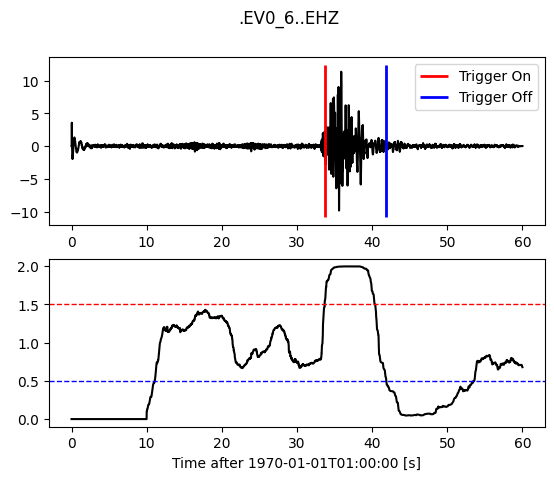

In [3]:
short_window = 5 #seconds
long_window = 10 #seconds
cft = classic_sta_lta(trace.data, int(short_window * df), int(long_window * df))
trigger_on = 1.5
trigger_off = 0.5
plot_trigger(trace, cft, trigger_on, trigger_off)

### STA/LTA for Noisy Waveform

In [4]:
noise = np.random.randn(len(trace.data))
noise_level = 1.0
noisy_trace = trace.copy()
noisy_trace.data += noise * noise_level / np.max(noise) * np.max(trace.data)

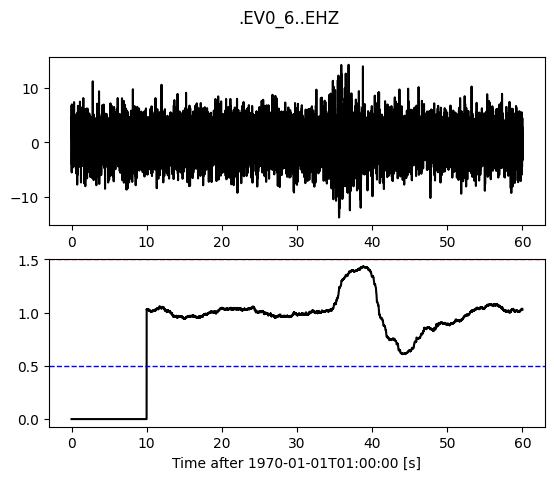

In [5]:
short_window = 5 #seconds
long_window = 10 #seconds
cft = classic_sta_lta(noisy_trace.data, int(short_window * df), int(long_window * df))
trigger_on = 1.5
trigger_off = 0.5
plot_trigger(noisy_trace, cft, trigger_on, trigger_off)

- TODO: Change the noise level to see how the STA/LTA characteristic function changes

- TODO: Find the STA/LTA window length that can detect the earthquake under noise level = 1.0
- TODO: Find the trigger threshold that can detect the earthquake under noise level = 1.0 

### Template matching

**Cut template**

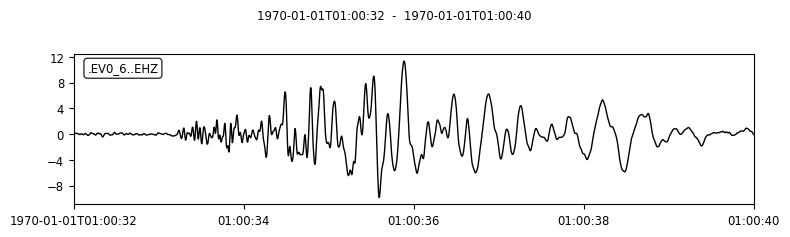

In [6]:
trace_cut = trace.copy()
trace_cut.trim(trace.stats.starttime + 32, trace.stats.starttime + 40)
trace_cut.plot();

**Run template matching**

In [7]:
def template_matching(data, template):
    data_len = len(data)
    template_len = len(template)
    scores = np.empty(data_len - template_len + 1)

    for i in range(data_len - template_len + 1):
        scores[i] = np.correlate(data[i:i+template_len], template)[0]

    best_match_idx = np.argmax(scores)
    return best_match_idx, scores


Best match : 32.0 seconds


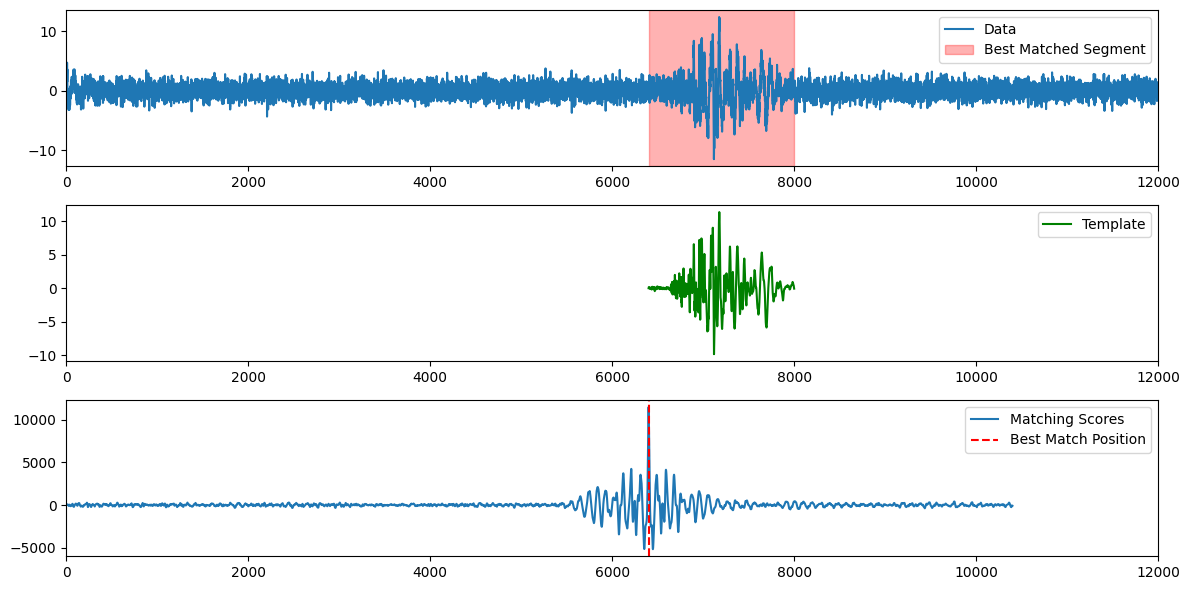

In [9]:
data = trace.data
template = trace_cut.data
noise = np.random.randn(len(data))

noise_level = 1.0
data = data + noise * noise_level

best_match_idx, scores = template_matching(data, template)
print("Best match :", best_match_idx / df, "seconds")

# Visualization
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(data, label="Data")
plt.axvspan(best_match_idx, best_match_idx + len(template), color='red', alpha=0.3, label="Best Matched Segment")
plt.xlim(0, len(data))
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(range(best_match_idx, best_match_idx + len(template)), template, label="Template", color="green")
plt.xlim(0, len(data))
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(scores, label="Matching Scores")
plt.axvline(best_match_idx, color='red', linestyle='--', label="Best Match Position")
plt.xlim(0, len(data))
plt.legend()

plt.tight_layout()
plt.show()


- TODO: Change the noise level to find the smallest detectable signal using template matching method? 
- TODO: Compare the detection capability of template matching with STA/LTA

- TODO: Think of ways to improve the detection capability of template matching?